In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import missingno as msno
import seaborn as sns

seed = 2022

In [2]:
# Load data
df = pd.read_csv("Assignment_data.csv")
df = df.iloc[:,1:]
df.head()

,loan_condition,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,all_util,total_rev_hi_lim,inq_fi,inq_last_12m,avg_cur_bal,mths_since_recent_inq,percent_bc_gt_75,total_bal_ex_mort,total_bc_limit,disbursement_method
0,Good Loan,14900,14900,36 months,20.39,556.71,Dd4,D4,Regional Revenue Manager,1 year,...,77.0,66900.0,0.0,2.0,16731.0,4.0,83.3,78737.0,48300.0,Cash
1,Good Loan,32000,32000,36 months,9.43,1024.01,Bb2,B1,Nurse Practitioner,2 years,...,59.0,43400.0,0.0,1.0,41250.0,10.0,33.3,105297.0,36600.0,Cash
2,Good Loan,10000,10000,36 months,6.08,304.59,Aa1,A2,Manicures,10+ years,...,41.0,56600.0,0.0,4.0,6762.0,2.0,9.1,39197.0,48000.0,Cash
3,Bad Loan,12000,12000,36 months,13.99,410.08,Cc3,C3,Claims Specialist,1 year,...,69.0,19300.0,2.0,1.0,2743.0,12.0,50.0,41152.0,8500.0,Cash
4,Good Loan,7000,7000,36 months,19.22,257.38,Dd4,D4,Security Officer,10+ years,...,NaN,15700.0,NaN,NaN,9558.0,1.0,50.0,21020.0,11400.0,Cash


In [3]:
# df.shape

In [4]:
#EDA

In [5]:
# df.describe()

In [6]:
# df.info()

In [7]:
import missingno as msno

# Examine the extent of missing data in the dataset
#msno.matrix(df, figsize=(10, 6), sparkline=True, labels=True)

# Display the percentage of missing values for each column
#missing_percentage = (df.isnull().sum() / len(df)) * 100
#missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

#if not missing_percentage.empty:
#    print("\nPercentage of missing values for each column:")
#    print(missing_percentage)
#else:
#    print("\nNo missing values in the dataset.")

In [8]:
# Convert the list of categorical variables to text for clarity and error prevention

categorical_list = [3,6,7,8,9,10,12,14,15,16,17,33,47,0]

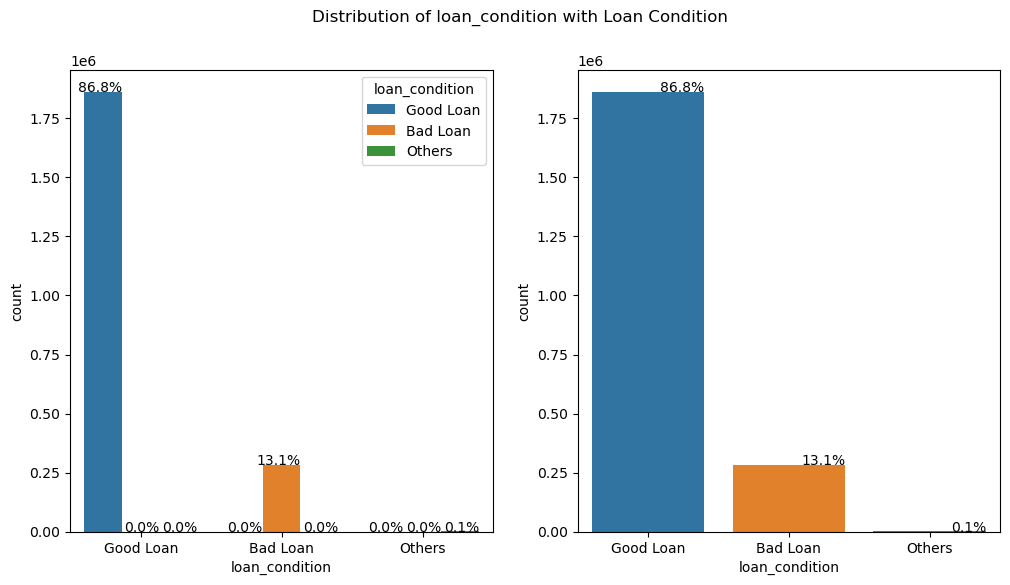

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical EDA Function
def categorical_EDA(data, feature):
    """
    Visualizes the distribution of a categorical feature and its relationship with the target variable.

    Parameters:
    - data: DataFrame, the dataset containing the feature and target variable.
    - feature: str, the categorical feature to be explored.

    Returns:
    - None, but plots two subplots for better insight.
    """

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot count distribution with loan_condition hue
    sns.countplot(x=feature, hue='loan_condition', data=data, ax=ax[0], order=data[feature].value_counts().iloc[:14].index)

    # Plot count distribution without loan_condition hue
    sns.countplot(x=feature, data=data, ax=ax[1], order=data[feature].value_counts().iloc[:14].index)

    # Set title
    fig.suptitle(f'Distribution of {feature} with Loan Condition')

    # Calculate percentage labels and annotate
    total = float(len(data))
    for i in range(2):
        for p in ax[i].patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width()
            y = p.get_height()
            ax[i].annotate(percentage, (x, y), ha="right")

    # Display the plot
    plt.show()

categorical_EDA(df, 'loan_condition')

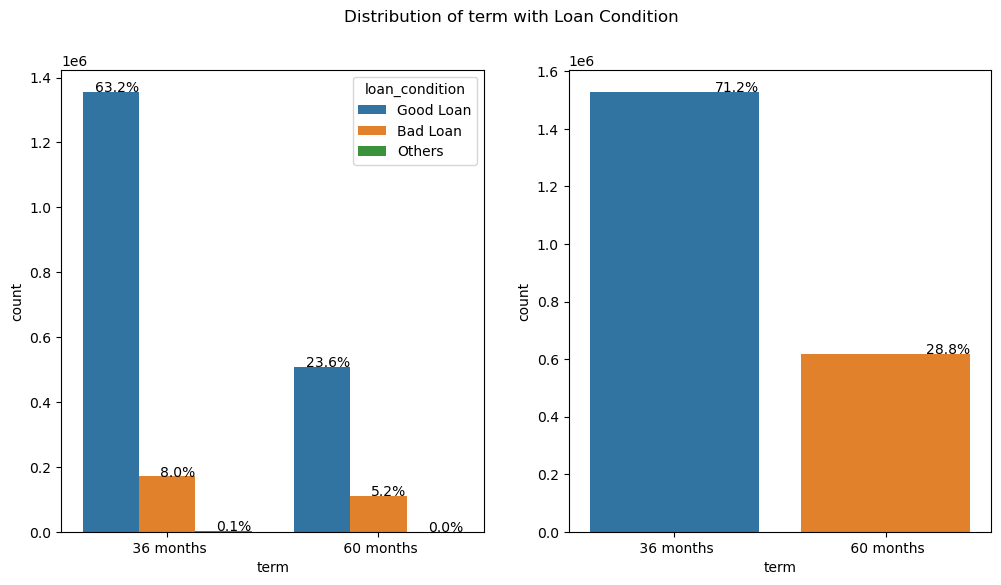

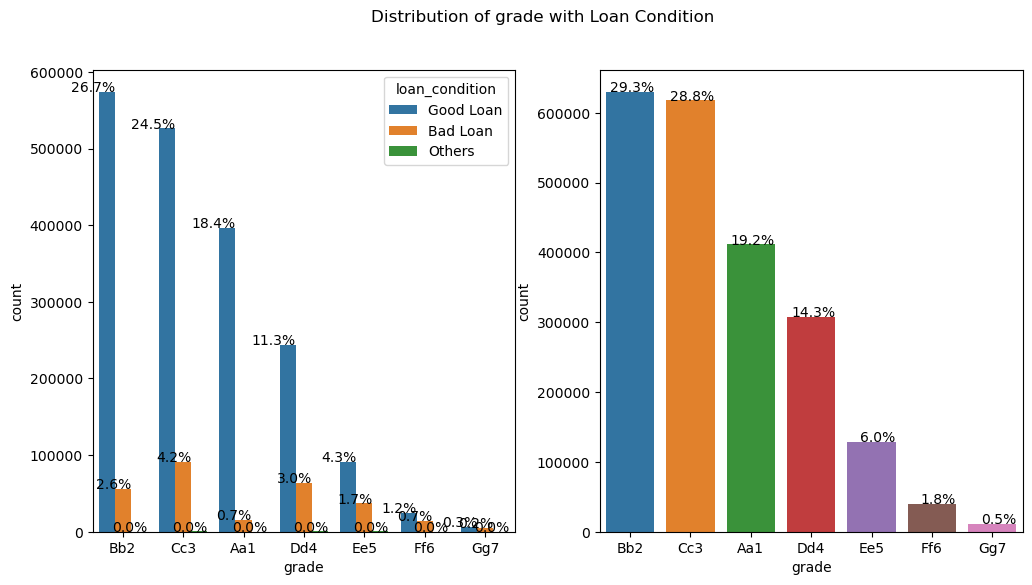

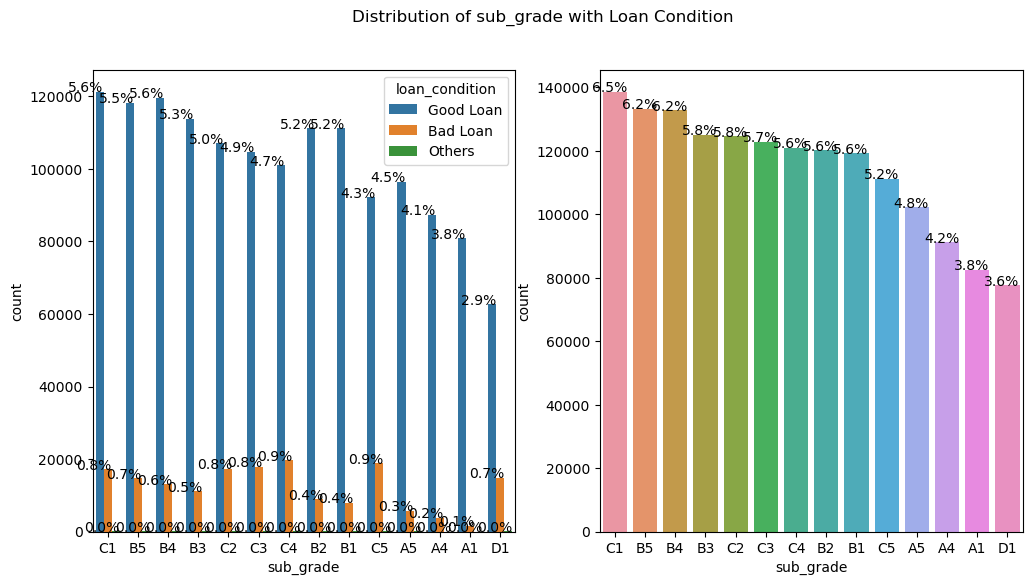

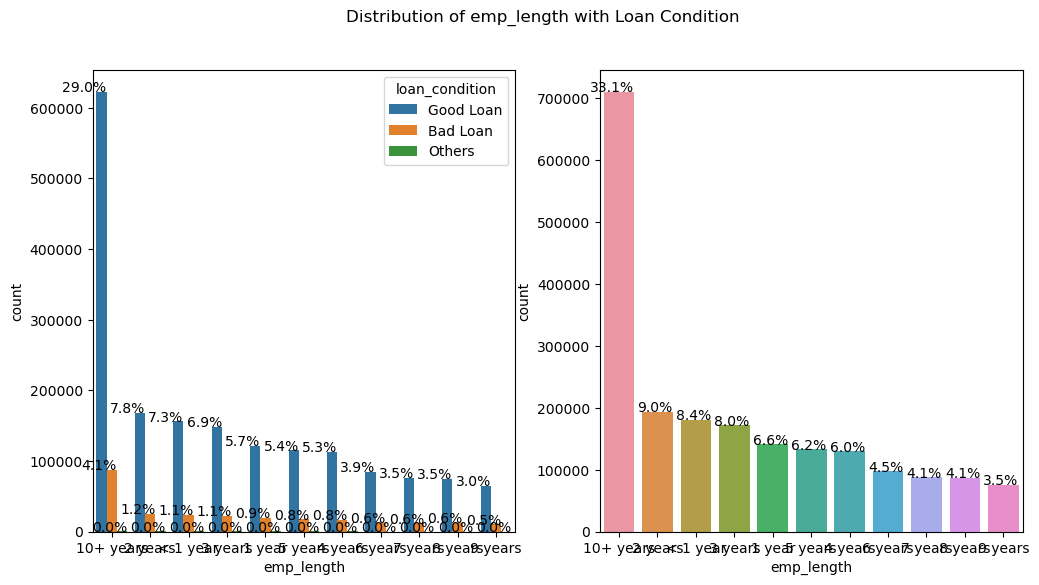

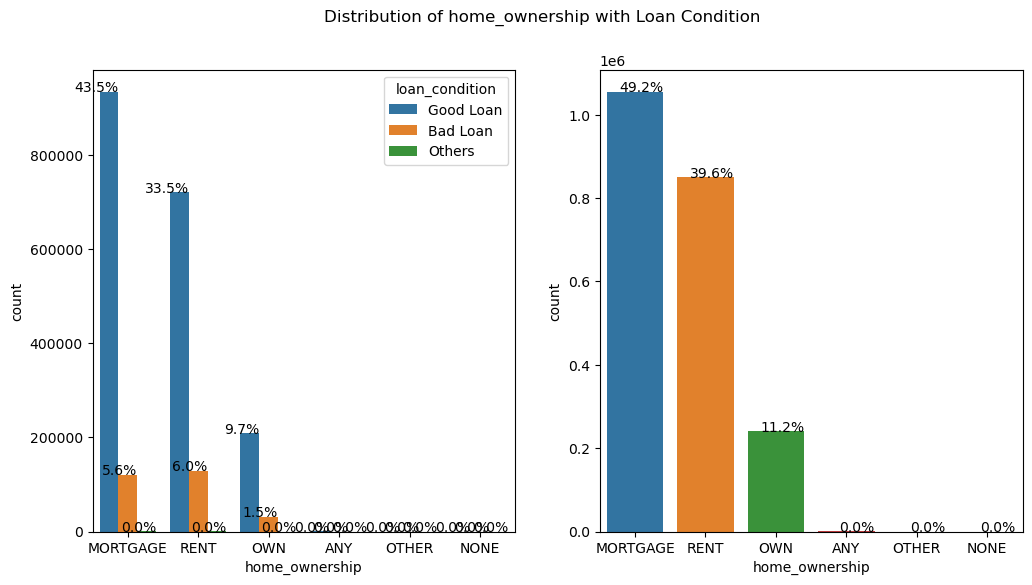

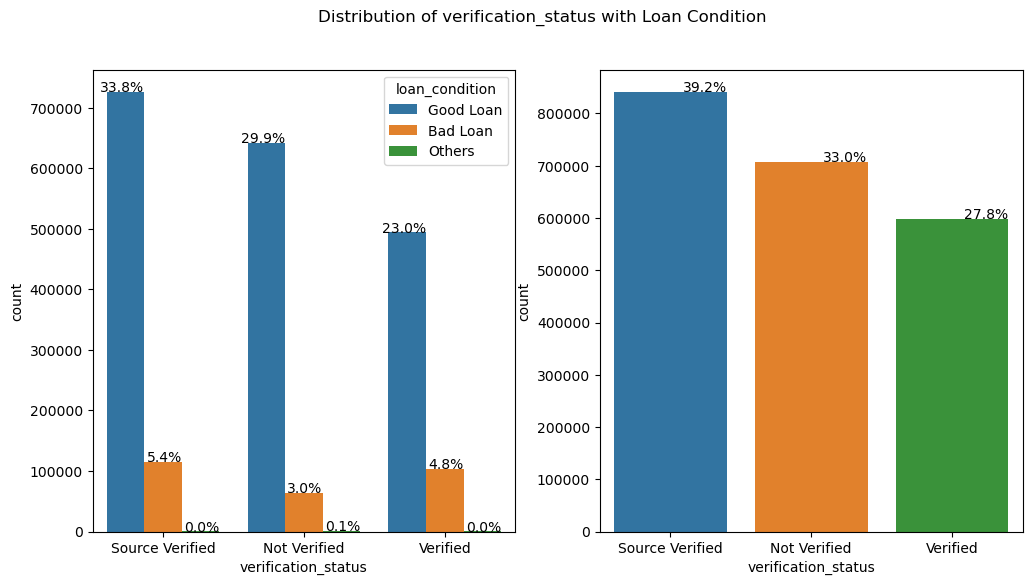

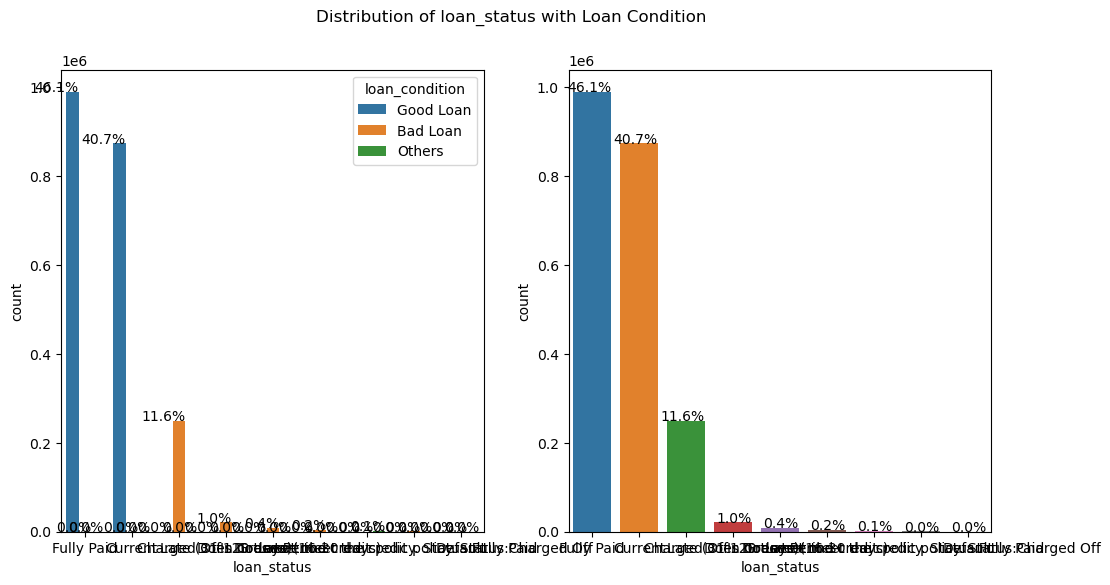

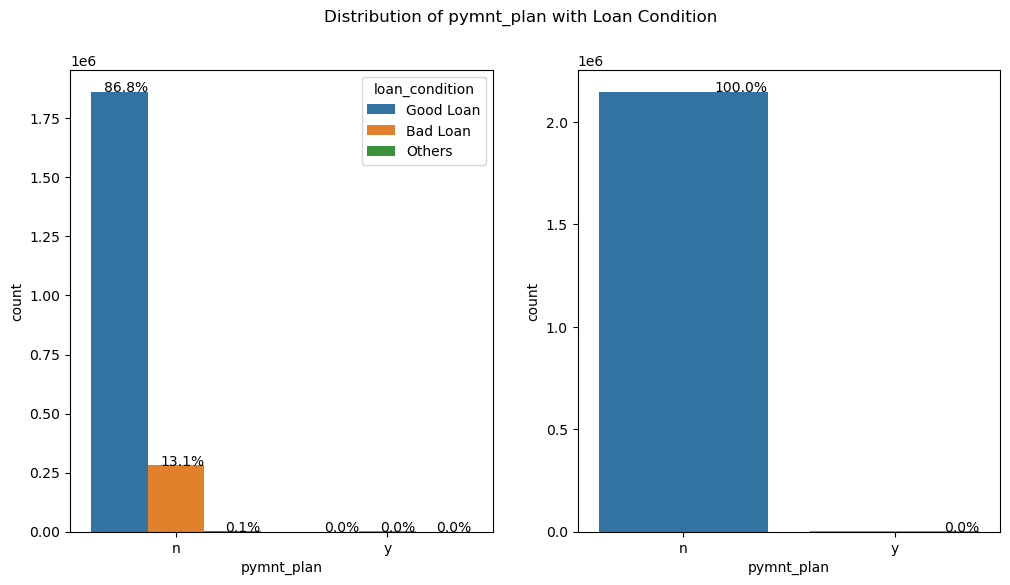

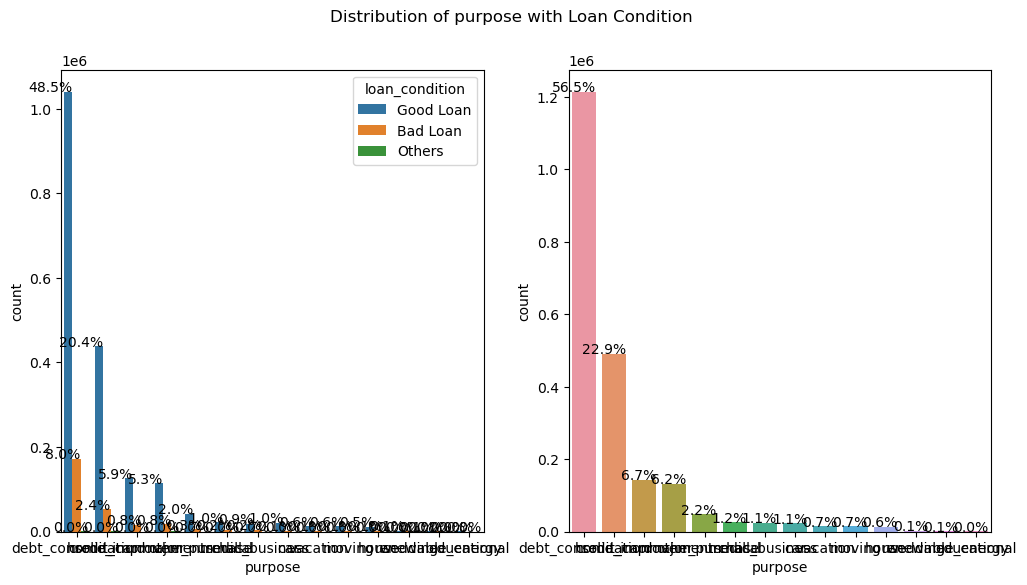

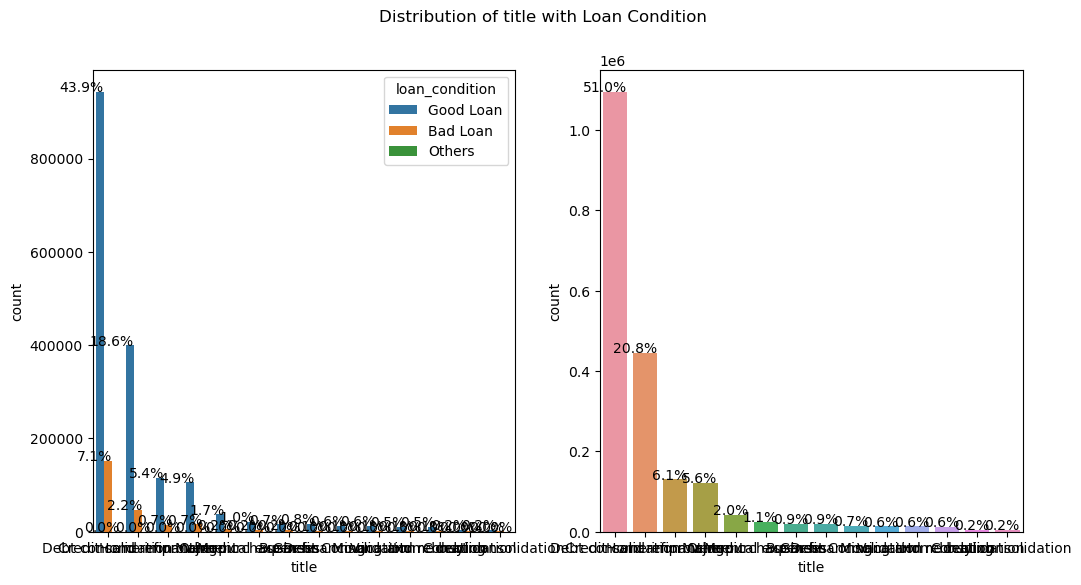

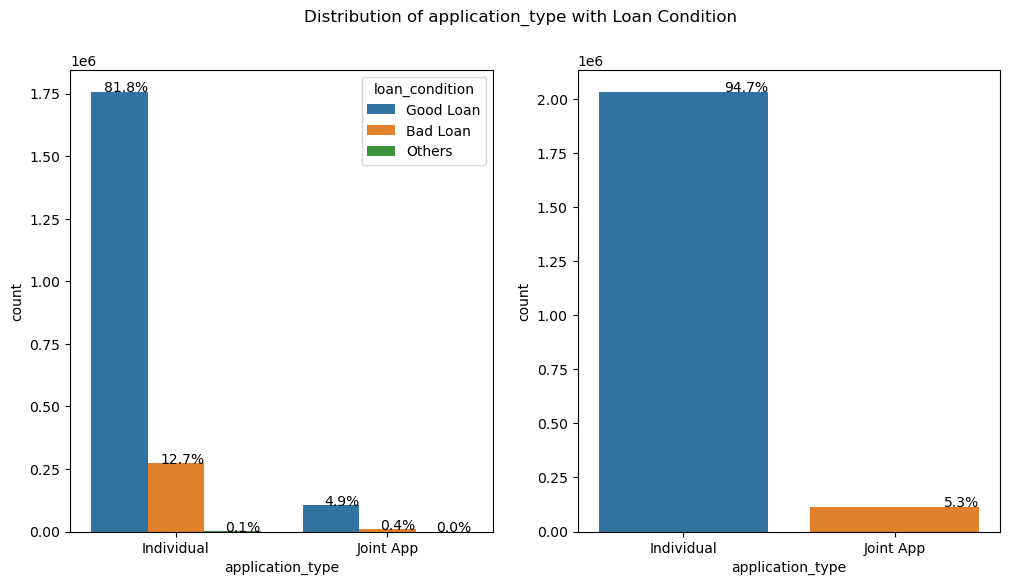

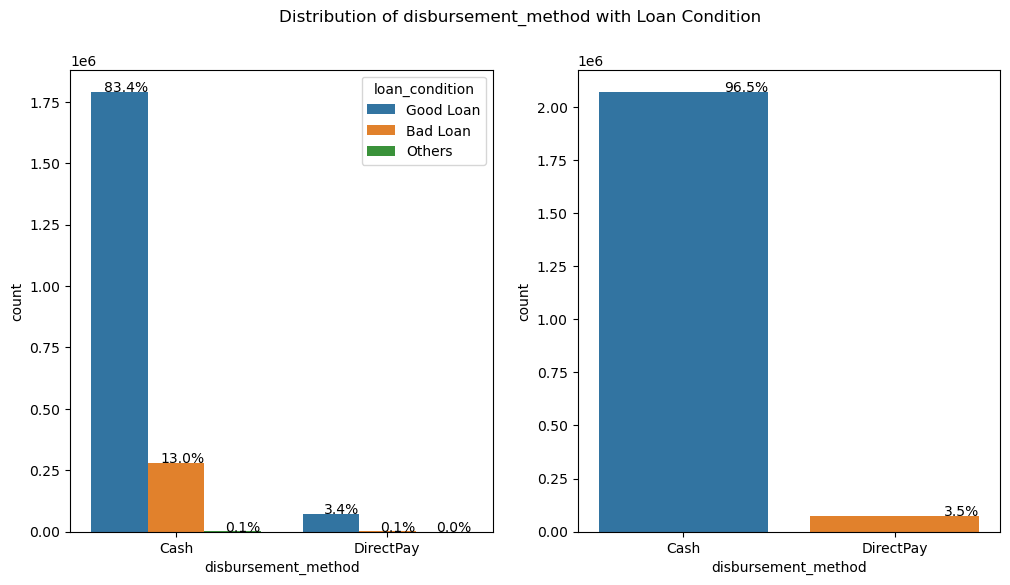

In [10]:
# List of categorical features to analyze
categorical_features = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                         'verification_status', 'loan_status', 'pymnt_plan', 'purpose',
                         'title', 'application_type', 'disbursement_method']

for feature in categorical_features:
    categorical_EDA(df, feature)

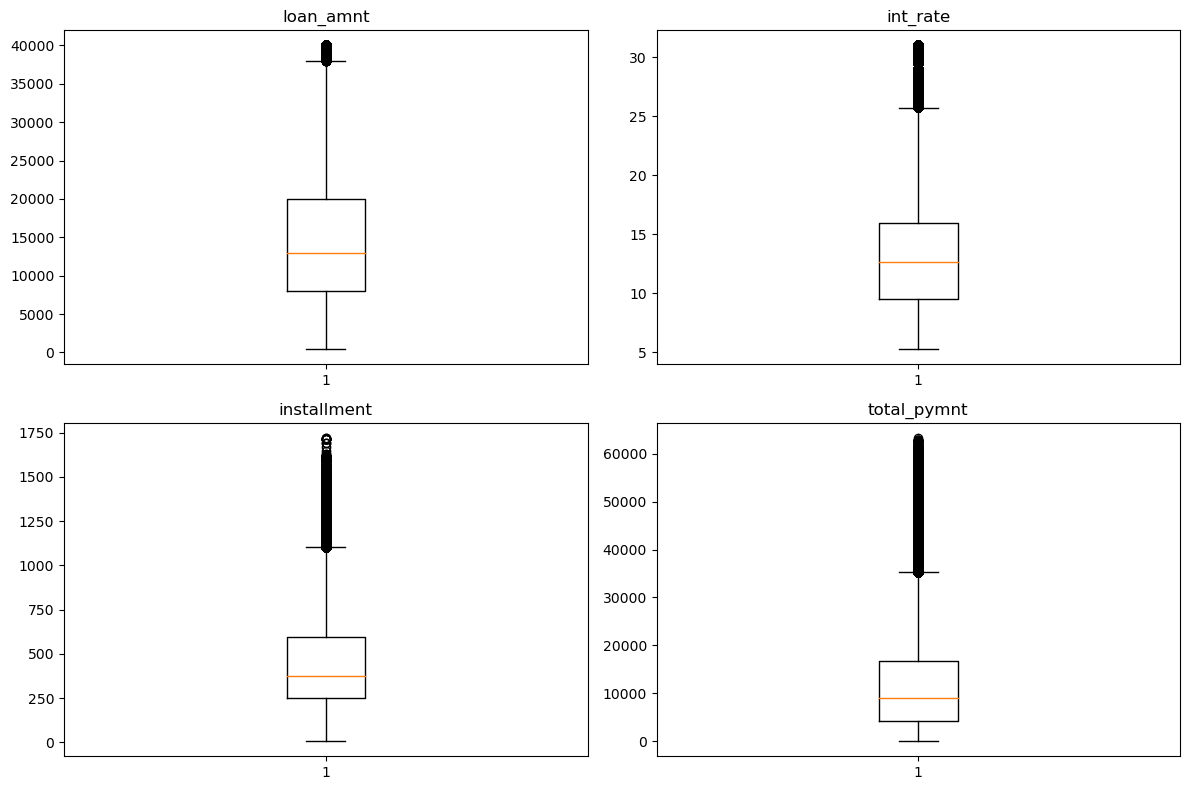

In [11]:
# EDA on Ordinal and Quantitative Variables

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# List of quantitative features to analyze
quantitative_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt']

# Loop through each quantitative feature and generate boxplots
for i, feature in enumerate(quantitative_features):
    row, col = divmod(i, 2)
    axs[row, col].boxplot(df[feature])
    axs[row, col].set_title(feature)

plt.tight_layout()
plt.show()

In [12]:
# Data Pre-processing

In [13]:
# Create a new column 'loan_condition2' and copy values from 'loan_condition'
df['loan_condition2'] = df['loan_condition']

# Convert 'loan_condition2' column to dummy variables
df = pd.get_dummies(df, columns=['loan_condition2'])

In [14]:
# Convert 'issue_d' to datetime format with specified format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Extract year and month from 'issue_d' and create new columns
df['year'] = pd.DatetimeIndex(df['issue_d']).year
df['month'] = pd.DatetimeIndex(df['issue_d']).month

In [15]:
# Remove records with 'Others' in loan_condition
df = df[df['loan_condition'] != 'Others']

In [16]:
# Questions 1 (4’):
# Q1a
# • From risk perspective, can you assess if the bank expands this program at adequate
# pace, or too slow/fast? Show insights at individual level and at portfolio/program
# level to support your assessment

In [17]:
# Plotting total nos of loans and total value of loans
df_loangroup = df.groupby('year').agg({'loan_amnt': ['sum', 'count']}).reset_index()
#df_loangroup

In [18]:
df_loangroup_year = df_loangroup['loan_amnt'].copy()
df_loangroup_year['year'] = df_loangroup['year']
df_loangroup_year['avg_loan_amt'] = df_loangroup_year['sum'] / df_loangroup_year['count']
#df_loangroup_year

In [19]:
#df_loangroup_year.plot(x='year', y='count', title='Total number of loans issued per year')
#plt.show()

In [20]:
# The bank substantially increased the volume of issued loans 
# from 2012 to 2014 and sustained this expansion from 2015 onward

In [21]:
#Q1 b
# You are asked to evaluate if those loans are priced adequately, 
# and evaluate how price evolves across time. 
# The bank management needs to determine if it is aligned
# with overall pricing strategy, i.e. pricing with risk in consideration. 
# Provide assessment and support with insights

In [22]:
#df_loangroup_year.plot(x='year', y='sum', xlabel='Year', ylabel='Total Loan Amount', title='Total Loan Amount Issued per Year')

In [23]:
#df_loangroup_year.plot(x='year', y='avg_loan_amt', xlabel='Year', ylabel='Average Loan Amount', title='Average Loan Amount Issued per Year')

In [24]:
# From 2013 onward, the average loan amount has remained stable at approximately $15,000

In [25]:
# Nos of loans issued by grade
df_grade = df.groupby(['grade', 'year']).size().reset_index(name='count')
#df_grade

In [26]:
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=df_grade, x='year', y='count', hue='grade')
#plt.title('Nos of Loans Issued by Grade per Year')
#plt.xlabel('Year')
#plt.ylabel('Nos of Loans')
#plt.show()

In [27]:
# The three primary loan grades, namely Aa1, Bb2, and Cc3, 
# exhibited a comparable growth trend from 2012 to 2015.

# However, starting in 2016, 
# the bank seems to have prioritized a more balanced risk profile, 
# concentrating its expansion efforts primarily on issuing Aa1 loans.

In [28]:
# Aggregate loan amounts by grade and year
df_grade2 = df.groupby(['grade', 'year'])['loan_amnt'].sum().reset_index()
#df_grade2

In [29]:
# Plotting the total value of loans by grade per year
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=df_grade2, x='year', y='loan_amnt', hue='grade')
#plt.title('Total Value of Loans by Grade per Year')

In [30]:
# Counting the nos of loans issued by purpose
df_purpose = df.groupby(['year', 'purpose']).size().reset_index(name='count')
#df_purpose

In [31]:
# Plotting the nos of loans by purpose per year
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=df_purpose, x='year', y='count', hue='purpose')
#plt.title('Nos of Loans by Purpose per Year')

In [32]:
# The majority of the loans issued were for debt consolidation or credit card purposes

In [33]:
# What is the average interest rate by grade over time? 
# Are the interest rates differentiated based on grades?

In [34]:
# Calculate the average interest rate by grade over time
df_grade = df[['year', 'grade', 'int_rate']].groupby(['year', 'grade']).agg(['mean']).reset_index()

df_grade_plot = df_grade['int_rate']
df_grade_plot['year'] = df_grade['year']
df_grade_plot['grade'] = df_grade['grade']

df_grade_plot = df_grade_plot.rename(columns={'mean': 'avg_int_rate'})

/var/folders/zp/88jsstbd46v5r43183whptph0000gn/T/ipykernel_42516/1049705864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grade_plot['year'] = df_grade['year']


In [35]:
#df_grade_plot

In [36]:
# Plotting average interest rate by grades over time
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=df_grade_plot, x='year', y='avg_int_rate', hue='grade')
#plt.title('Average Interest Rate by Grades over Time')
#plt.xlabel('Year')
#plt.ylabel('Average Interest Rate')
#plt.legend(title='Grade', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
#plt.show()

In [37]:
# There is a gradual rise in interest rates across the majority of loan grades. 

# Aa1 grades, representing loans with the lowest risk, remain below 10%. 

# Conversely, Gg7 loans, considered the most risky, 
# experienced an almost twofold increase in their interest rates, 
# climbing from 17% in 2007 to over 30% in 2018. 

# The gap between loan grades remains consistent and 
# nearly evenly distributed across different grades and years.

In [38]:
# Questions 2 (4’):
# • How does the portfolio default look like across year?
# o Does it get better over year? If no, what are the possible reasons

# • Does the bank have the effective credit assessment method to grade them?
# Elaborate. If not, what are your suggestions

In [39]:
# Proportion of defaulting loans to total loans over time

In [40]:
# Create a pivot table to calculate the nos of bad loans and good loans over time
df_loan_status = pd.pivot_table(df, index=['year'], values=['loan_condition2_Bad Loan', 'loan_condition2_Good Loan'], aggfunc=np.sum)
#df_loan_status

In [41]:
# Calculate the total count and non-performing loan ratio using loan_status
df_loan_status['total_count'] = df_loan_status['loan_condition2_Bad Loan'] + df_loan_status['loan_condition2_Good Loan']
df_loan_status['Non-performing loan ratio'] = df_loan_status['loan_condition2_Bad Loan'] / df_loan_status['total_count']

In [42]:
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=df_loan_status, x='year', y='Non-performing loan ratio', label='Non-Performing Loan Ratio', marker='o')
#plt.title('Ratio of Non-Performing Loans over Time')
#plt.xlabel('Year')
#plt.ylabel('Non-Performing Loan Ratio')
#plt.grid(True)
#plt.legend()
#plt.show()

In [43]:
# From 2009 to 2016, the percentage of bad loans remained consistently 
# at approximately 15% of the total loans issued. 

# However, starting in 2017, the bank's strategic shift towards 
# issuing more Aa1-grade loans led to 
# a significant reduction in the bad loan ratio, bringing it down to less than 5%.

In [44]:
# Compute the bad loan ratio based on loan grades

In [45]:
df_NPL_grade = pd.pivot_table(df,index=['year', 'grade'],values=['loan_condition2_Bad Loan', 'loan_condition2_Good Loan'], aggfunc=np.sum).reset_index()
#df_NPL_grade

In [46]:
df_NPL_grade['total_count'] = df_NPL_grade['loan_condition2_Bad Loan'] + df_NPL_grade['loan_condition2_Good Loan']
df_NPL_grade['Non-performing loan ratio'] = df_NPL_grade['loan_condition2_Bad Loan'] / df_NPL_grade['total_count']
#df_NPL_grade.tail(10)

In [47]:
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=df_NPL_grade, x='year', y='Non-performing loan ratio', hue='grade', palette='viridis')
#plt.title('Ratio of Non-Performing Loans by Grade over time')
#plt.legend(title='Grade', bbox_to_anchor=(1, 1), loc='upper left')
#plt.show()

In [48]:
# The bank's creditworthiness is evident in the Non-Performing loan ratios 
# across different loan grades, with Aa1 exhibiting the lowest ratio 
# and Gg7 having the highest. 

# Notably, there seems to be a tightening of assessment criteria in 2017, 
# leading to reduced non-performing loans across all grades.

# Furthermore, in 2018, 
# approximately half of the total bank loans were comprised of Aa1 and Bb2 loans, 
# both with Non-Performing loan ratios below 0.03. 

# This indicates a manageable level of risk. 
# Nevertheless, proactive customer follow-up for bad loans is 
# advisable to provide guidance on loan repayment.

In [49]:
# Questions 3 (8’):
# • Can you enhance the credit model? You can leverage on existing credit rating and
# build a model. You need to demonstrate
# o Parameters used
# o Evaluation of the model

# • Are there any data quality issues in the data collected by the bank? Any suggestion?

In [50]:
# Utilizing machine learning can enhance the credit model, 
# leading to improved accuracy in predicting bad loans

df['loan_condition'] = df['loan_condition'].map({'Good Loan': 0, 'Bad Loan': 1})

In [51]:
# Fill missing values
df['emp_length'].fillna('Unknown', inplace=True)

# Map employment lengths to numeric values
emp_length_mapping = {
    '1 year': 2.0,
    '10+ years': 11.0,
    '2 years': 3.0,
    '3 years': 4.0,
    '4 years': 5.0,
    '5 years': 6.0,
    '6 years': 7.0,
    '7 years': 8.0,
    '8 years': 9.0,
    '9 years': 10.0,
    '< 1 year': 1.0,
    'Unknown': 0.0
}

df['emp_length'].replace(emp_length_mapping, inplace=True)

In [52]:
# Map loan status categories
loan_status_mapping = {
    'Late (31-120 days)': 'Late_31_120_days',
    'Late (16-30 days)': 'Late_16_30_days',
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Charged Off'
}

df['loan_status'].replace(loan_status_mapping, inplace=True)

In [53]:
# Map home ownership categories
home_ownership_mapping = {
    'NONE': 0,
    'OTHER': 0,
    'ANY': 1,
    'RENT': 1,
    'MORTGAGE': 2,
    'OWN': 3
}

df['home_ownership'].replace(home_ownership_mapping, inplace=True)

In [54]:
#df.columns

In [55]:
#df.isnull().sum()

In [56]:
# Rebalance class by undersampling Good Loans
# Class count
class_count_0, class_count_1 = df['loan_condition'].value_counts()

# Separate classes
class_0 = df[df['loan_condition'] == 0]
class_1 = df[df['loan_condition'] == 1]

# Display class shapes
print('Good Loans:', class_0.shape)
print('Bad Loans:', class_1.shape)

Good Loans: (1863565, 53)
Bad Loans: (282181, 53)


Total count of 1 and 0: loan_condition
0    282181
1    282181
Name: count, dtype: int64


<Axes: title={'center': 'Count (Target)'}, xlabel='loan_condition'>

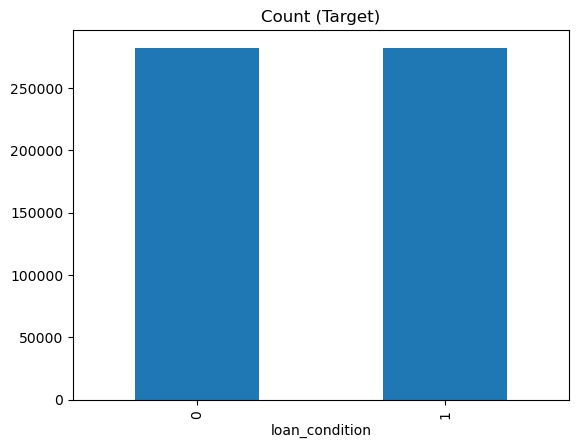

In [57]:
# Undersample Good Loans to balance classes
class_0_under = class_0.sample(class_count_1, random_state=42)

# Concatenate undersampled Good Loans with Bad Loans
df_undersample = pd.concat([class_0_under, class_1], axis=0)

# Display the total count of each class
print("Total count of 1 and 0:", df_undersample['loan_condition'].value_counts())

# Plot the count after undersampling
df_undersample['loan_condition'].value_counts().plot(kind='bar', title='Count (Target)')

In [58]:
#df_undersample.columns

In [59]:
# Select variables for modeling
selected_columns = ['year', 'loan_condition', 'loan_amnt', 'term', 'int_rate', 'emp_length', 'grade', 'sub_grade', 'annual_inc', 'open_acc',
                     'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                     'last_pymnt_amnt', 'tot_cur_bal', 'open_acc_6m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'inq_last_12m', 'avg_cur_bal',
                     'mths_since_recent_inq', 'percent_bc_gt_75', 'total_bal_ex_mort', 'total_bc_limit']

df2 = df_undersample[selected_columns]
df_all = df_undersample

In [60]:
# Create dummies for categorical variables in df2
categorical_columns = ['year', 'term', 'emp_length', 'grade', 'sub_grade']
df2 = pd.get_dummies(df2, columns=categorical_columns, drop_first=True)
#df2

In [61]:
# Drop specified columns in df_all
columns_to_drop = ['emp_title', 'issue_d', 'title', 'addr_state', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
df_all.drop(columns=columns_to_drop, inplace=True)
#df_all

In [62]:
# Create dummies for categorical variables in df_all
categorical_columns = ['year', 'term', 'emp_length', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'application_type', 'disbursement_method']
df_all = pd.get_dummies(df_all, columns=categorical_columns, drop_first=True)
#df_all

In [63]:
# Train-Test Split

# Set X and y for df2
y2 = df2['loan_condition']
X2 = df2.drop(columns=['loan_condition'])

# Set X and y for df_all
y_all = df_all['loan_condition']
X_all = df_all.drop(columns=['loan_condition'])

In [64]:
X2

,loan_amnt,int_rate,annual_inc,open_acc,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
595879,35000,9.49,300000.0,23.0,34.0,7700.04,7645.04,32862.580000,32627.85,27299.96,...,False,False,False,False,False,False,False,False,False,False
294381,18000,12.35,75000.0,11.0,28.0,0.00,0.00,21498.010005,21498.01,18000.00,...,False,False,False,False,False,False,False,False,False,False
173215,25000,10.99,80000.0,15.0,32.0,0.00,0.00,29429.536868,29429.54,25000.00,...,False,False,False,False,False,False,False,False,False,False
236120,9600,9.16,60500.0,9.0,12.0,0.00,0.00,11010.813385,11010.81,9600.00,...,False,False,False,False,False,False,False,False,False,False
590393,20950,13.99,90000.0,11.0,32.0,0.00,0.00,28764.270844,28764.27,20950.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147561,5150,18.99,19000.0,8.0,10.0,0.00,0.00,4570.390000,4570.39,2948.03,...,False,False,False,False,False,False,False,False,False,False
2147589,10000,12.49,90000.0,7.0,15.0,0.00,0.00,3679.390000,3679.39,2670.58,...,False,False,False,False,False,False,False,False,False,False
2147594,3200,15.05,32000.0,12.0,16.0,0.00,0.00,1338.160000,1338.16,670.85,...,False,False,False,False,False,False,False,False,False,False
2147612,8500,10.99,29000.0,7.0,16.0,0.00,0.00,6394.330000,6394.33,5104.57,...,False,False,False,False,False,False,False,False,False,False


In [65]:
#X_all.columns

In [66]:
#seed = 2022

In [67]:
# Split X2 data with 20% cross-validation for df2
X2_train, X2_cv, y2_train, y2_cv = train_test_split(X2, y2, test_size=0.2, random_state=seed)
print(f"Training set: X2_train shape - {X2_train.shape}, y2_train shape - {y2_train.shape}")
print(f"Cross-validation set: X2_cv shape - {X2_cv.shape}, y2_cv shape - {y2_cv.shape}")

Training set: X2_train shape - (451489, 86), y2_train shape - (451489,)
Cross-validation set: X2_cv shape - (112873, 86), y2_cv shape - (112873,)


In [68]:
# Split X_all data with 20% cross-validation for df_all
X_all_train, X_all_cv, y_all_train, y_all_cv = train_test_split(X_all, y_all, test_size=0.2, random_state=seed)
print(f"Training set: X_all_train shape - {X_all_train.shape}, y_all_train shape - {y_all_train.shape}")
print(f"Cross-validation set: X_all_cv shape - {X_all_cv.shape}, y_all_cv shape - {y_all_cv.shape}")

Training set: X_all_train shape - (451489, 123), y_all_train shape - (451489,)
Cross-validation set: X_all_cv shape - (112873, 123), y_all_cv shape - (112873,)


In [69]:
%config Completer.use_jedi = False
%config IPCompleter.greedy=True

In [70]:
# XGBoost with Gridsearch

from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import time

desired_size = 1000

# Downsample the training set
X2_train_downsampled, y2_train_downsampled = resample(X2_train, y2_train, n_samples=desired_size, random_state=seed)

# Downsample the validation set (X2_cv, y2_cv)
X2_cv_downsampled, y2_cv_downsampled = resample(X2_cv, y2_cv, n_samples=desired_size, random_state=seed)

# Define the XGBoost classifier
xg_class = xgb.XGBClassifier()

# Define the hyperparameter grid
parameters = {'nthread': [-1],
              'objective': ['binary:logistic'],
              'learning_rate': [0.1, 0.15, 0.2],
              'max_depth': [5, 7],
              'n_estimators': [50, 70],
              'random_state': [seed]}

# Perform grid search
xgb_grid = GridSearchCV(xg_class, parameters, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model with downsampled training data and measure the execution time
start_time = time.time()
xgb_grid.fit(X2_train_downsampled, y2_train_downsampled)
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Print the best parameters and best score from the grid search
print("-" * 50)
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))

# Predict the target on downsampled validation dataset
predictions = xgb_grid.predict(X2_cv_downsampled)

# View the Classification report
print(classification_report(y2_cv_downsampled, predictions))


Training time: 6.160717964172363 seconds
--------------------------------------------------
Best: 0.967639 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 70, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 2022}
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       513
           1       0.95      0.84      0.90       487

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



In [71]:
# The XGBoost model demonstrates a recall rate of 84%, 
# a metric of greater significance than its 95% precision. 

# Models using LightGBM and XGBoost were constructed 
# using carefully selected variables to forecast 
# whether a customer would default on a loan. 

# The selected variables encompassed predominantly numerical data, 
# and certain categorical data were subjected to one-hot encoding.

In [ ]:
# Are there any data quality issues in the data collected by the bank? Any suggestion?

# The output of `df.isnull().sum()` reveals 
# the count of missing values for each column in the DataFrame:

#1. emp_title: 158,575 missing
#2. title: 22,194 missing
#3. inq_last_6mths: 4 missing
#4. mths_since_last_record: 1,805,055 missing
#5. open_acc: 3 missing
#6. total_acc: 3 missing
#7. last_pymnt_d: 2,309 missing
#8. next_pymnt_d: 1,238,491 missing
#9. last_credit_pull_d: 65 missing
#10. annual_inc_joint: 2,030,962 missing
#11. tot_cur_bal: 64,932 missing
#12. Several other columns have a significant number of
# missing values related to account details.

# Handling missing values is crucial, and 
# the approach depends on the specific analysis or modeling tasks.


# Outliers have been observed in the following variables 'loan_amnt', 'int_rate'
# 'installment' ,  'total_pymnt'



# An imbalance ratio of 0.1514 suggests that the majority 
# class outnumbers the minority class by approximately 0.1514 times in  dataset. 
# In binary classification, a ratio less than 1 indicates class imbalance, 
# where one class (typically the negative or "0" class) 
# is more prevalent than the other (positive or "1" class). 


# suggestion

# Addressing missing data and outliers is vital for ensuring dataset quality. 
# Suggestions include identifying reasons for missing data, 
# utilizing appropriate imputation methods, 
# considering advanced techniques for complex datasets, 
# identifying outliers via statistical methods, 
# deciding whether to remove or transform outliers, and 
# conducting thorough exploratory data analysis. 
# Documentation is crucial for transparency, recording methods used, and 
# maintaining a record of affected variables. 
# Validate the impact of data quality efforts by comparing analysis performance before
# and after addressing missing data and outliers. 
# Context and project goals should guide specific actions taken.

In [72]:
import pandas as pd

# Assuming 'loan_condition' is your target variable
class_distribution = df['loan_condition'].value_counts()

print("Class Distribution:")
print(class_distribution)

# Calculate imbalance ratio
imbalance_ratio = class_distribution[1] / class_distribution[0]

print("\nImbalance Ratio:", imbalance_ratio)

Class Distribution:
loan_condition
0    1863565
1     282181
Name: count, dtype: int64

Imbalance Ratio: 0.15141999339974727


In [ ]:
# Questions 4 (4’):
# • If you are allowed to keep 70% of the existing total program limit, what are the
# things to be considered to maximize the expected return of the bank


# If retaining only 70% of the existing program limit, adjust interest rates strategically. 
# Analyze whether uniform adjustments or specific targeting by loan grades are more 
# effective, considering potential competitiveness impacts. 
# The Expected Value Framework aligns ML results with profit maximization, 
# factoring in expected profit, loss from bad loans, and prediction probabilities. 
# Key considerations include interest rate adjustments, 
# competitiveness analysis, risk management, 
# Expected Value Framework application, customer retention, 
# regulatory compliance, and monitoring and adaptation. 
# Careful consideration of these factors enables the bank to develop a strategic plan 
# for maximizing expected return within the 70% program limit.






# • Assume you have figured out what to do and execute it within 70% of the original
# limit, your portfolio starts to show attritions, what do you want to do?
# o Hint: what will lead to customer attrition? what analysis do you need to do
# before deciding what to do


# To address attrition caused by unattractive interest rates, 
# analyze the characteristics of attriting customers. 
# This guides the front office in identifying those prone to attrition. 
# Conduct competitor analyses to understand reasons for attrition. 
# Formulate an optimization problem with competitor data as constraints, 
# allowing loan officers to determine optimal loan terms 
# for maximizing profitability and tackling attrition effectively.